In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from scipy.stats import skew
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn import metrics
import numpy as np
import pickle

In [3]:
df = pd.read_csv('Copper_Set.csv', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             181671 non-null  object 
 1   item_date      181672 non-null  float64
 2   quantity tons  181673 non-null  object 
 3   customer       181672 non-null  float64
 4   country        181645 non-null  float64
 5   status         181671 non-null  object 
 6   item type      181673 non-null  object 
 7   application    181649 non-null  float64
 8   thickness      181672 non-null  float64
 9   width          181673 non-null  float64
 10  material_ref   103754 non-null  object 
 11  product_ref    181673 non-null  int64  
 12  delivery date  181672 non-null  float64
 13  selling_price  181672 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 19.4+ MB


In [4]:
df.shape

(181673, 14)

In [5]:
df.isna().sum()

id                   2
item_date            1
quantity tons        0
customer             1
country             28
status               2
item type            0
application         24
thickness            1
width                0
material_ref     77919
product_ref          0
delivery date        1
selling_price        1
dtype: int64

In [6]:
#Checking the unique items
for i in list(df.columns):
    print(f"{i} : {df[i].nunique()}")

id : 181671
item_date : 252
quantity tons : 181673
customer : 1169
country : 17
status : 9
item type : 7
application : 30
thickness : 594
width : 1386
material_ref : 16563
product_ref : 33
delivery date : 28
selling_price : 9795


In [7]:
#Converting Datatype from Object to Numeric
df['quantity tons'] = pd.to_numeric(df['quantity tons'], errors='coerce')
df['customer'] = pd.to_numeric(df['customer'], errors='coerce')
df['country'] = pd.to_numeric(df['customer'], errors='coerce')

In [8]:
#Converting date columns to Date datatype
df['item_date'] = pd.to_datetime(df['item_date'], format='%Y%m%d', errors='coerce').dt.date
df['delivery date'] = pd.to_datetime(df['delivery date'], format='%Y%m%d', errors='coerce').dt.date
df['item_date'] = pd.to_datetime(df['item_date'])
df['delivery date'] = pd.to_datetime(df['delivery date'])
df['delivery_time_taken'] = (df['item_date'] - df['delivery date']).dt.days

In [9]:
df['material_ref']=df['material_ref'].apply(lambda x: np.nan if str(x).startswith('00000') else x)
df.isnull().sum()

id                          2
item_date                   3
quantity tons               1
customer                    1
country                     1
status                      2
item type                   0
application                24
thickness                   1
width                       0
material_ref           100645
product_ref                 0
delivery date               3
selling_price               1
delivery_time_taken         6
dtype: int64

In [10]:
df.drop(columns=['id','item_date','delivery date','material_ref'],inplace=True)
df

,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,selling_price,delivery_time_taken
0,54.151139,30156308.0,30156308.0,Won,W,10.0,2.00,1500.0,1670798778,854.00,-91.0
1,768.024839,30202938.0,30202938.0,Won,W,41.0,0.80,1210.0,1668701718,1047.00,0.0
2,386.127949,30153963.0,30153963.0,Won,WI,28.0,0.38,952.0,628377,644.33,90.0
3,202.411065,30349574.0,30349574.0,Won,S,59.0,2.30,1317.0,1668701718,768.00,90.0
4,785.526262,30211560.0,30211560.0,Won,W,10.0,4.00,2000.0,640665,577.00,31.0
...,...,...,...,...,...,...,...,...,...,...,...
181668,102.482422,30200854.0,30200854.0,Won,W,41.0,0.96,1220.0,164141591,591.00,1.0
181669,208.086469,30200854.0,30200854.0,Won,W,41.0,0.95,1500.0,164141591,589.00,1.0
181670,4.235594,30200854.0,30200854.0,Won,W,41.0,0.71,1250.0,164141591,619.00,1.0
181671,-2000.000000,30200854.0,30200854.0,Won,W,41.0,0.85,1250.0,164141591,601.00,1.0


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity tons,181672.0,5.874926e+03,2.349081e+06,-2000.00,1.097030e+01,3.036464e+01,6.716061e+01,1.000000e+09
customer,181672.0,3.051221e+07,2.433382e+07,12458.00,3.019688e+07,3.020524e+07,3.028042e+07,2.147484e+09
country,181672.0,3.051221e+07,2.433382e+07,12458.00,3.019688e+07,3.020524e+07,3.028042e+07,2.147484e+09
application,181649.0,2.561581e+01,1.775417e+01,2.00,1.000000e+01,1.500000e+01,4.100000e+01,9.900000e+01
thickness,181672.0,2.564827e+00,6.572321e+00,0.18,7.000000e-01,1.500000e+00,3.000000e+00,2.500000e+03
width,181673.0,1.295287e+03,2.616318e+02,1.00,1.180000e+03,1.250000e+03,1.500000e+03,2.990000e+03
product_ref,181673.0,4.739679e+08,7.175101e+08,611728.00,6.119930e+05,6.406650e+05,1.332077e+09,1.722208e+09
selling_price,181672.0,1.918036e+03,3.317956e+05,-1160.00,6.690000e+02,8.120000e+02,9.530000e+02,1.000010e+08
delivery_time_taken,181667.0,-5.999123e+01,4.681328e+01,-448.00,-9.700000e+01,-5.900000e+01,-2.800000e+01,6.890000e+02


In [12]:
#Replace Negative or Zero values
df['quantity tons']=df['quantity tons'].apply(lambda x: np.nan if x<=0 else x)
df['selling_price']=df['selling_price'].apply(lambda x: np.nan if x<=0 else x)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity tons,181668.0,5.875066e+03,2.349107e+06,0.00001,1.097122e+01,3.036501e+01,6.716134e+01,1.000000e+09
customer,181672.0,3.051221e+07,2.433382e+07,12458.00000,3.019688e+07,3.020524e+07,3.028042e+07,2.147484e+09
country,181672.0,3.051221e+07,2.433382e+07,12458.00000,3.019688e+07,3.020524e+07,3.028042e+07,2.147484e+09
application,181649.0,2.561581e+01,1.775417e+01,2.00000,1.000000e+01,1.500000e+01,4.100000e+01,9.900000e+01
thickness,181672.0,2.564827e+00,6.572321e+00,0.18000,7.000000e-01,1.500000e+00,3.000000e+00,2.500000e+03
width,181673.0,1.295287e+03,2.616318e+02,1.00000,1.180000e+03,1.250000e+03,1.500000e+03,2.990000e+03
product_ref,181673.0,4.739679e+08,7.175101e+08,611728.00000,6.119930e+05,6.406650e+05,1.332077e+09,1.722208e+09
selling_price,181665.0,1.918124e+03,3.318020e+05,0.10000,6.690000e+02,8.120000e+02,9.530000e+02,1.000010e+08
delivery_time_taken,181667.0,-5.999123e+01,4.681328e+01,-448.00000,-9.700000e+01,-5.900000e+01,-2.800000e+01,6.890000e+02


In [13]:
df.isnull().sum()

quantity tons           5
customer                1
country                 1
status                  2
item type               0
application            24
thickness               1
width                   0
product_ref             0
selling_price           8
delivery_time_taken     6
dtype: int64

In [14]:
#Handling Null values using median and mode
df['status'].fillna(df['status'].mode().iloc[0], inplace=True)

In [15]:
df['quantity tons'].fillna(df['quantity tons'].median(),inplace=True)
df['customer'].fillna(df['customer'].median(),inplace=True)
df['country'].fillna(df['country'].median(),inplace=True)
df['application'].fillna(df['application'].median(),inplace=True)
df['thickness'].fillna(df['thickness'].median(),inplace=True)
df['selling_price'].fillna(df['selling_price'].median(),inplace=True)
df['delivery_time_taken'].fillna(df['delivery_time_taken'].median(),inplace=True)

In [16]:
df

,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,selling_price,delivery_time_taken
0,54.151139,30156308.0,30156308.0,Won,W,10.0,2.00,1500.0,1670798778,854.00,-91.0
1,768.024839,30202938.0,30202938.0,Won,W,41.0,0.80,1210.0,1668701718,1047.00,0.0
2,386.127949,30153963.0,30153963.0,Won,WI,28.0,0.38,952.0,628377,644.33,90.0
3,202.411065,30349574.0,30349574.0,Won,S,59.0,2.30,1317.0,1668701718,768.00,90.0
4,785.526262,30211560.0,30211560.0,Won,W,10.0,4.00,2000.0,640665,577.00,31.0
...,...,...,...,...,...,...,...,...,...,...,...
181668,102.482422,30200854.0,30200854.0,Won,W,41.0,0.96,1220.0,164141591,591.00,1.0
181669,208.086469,30200854.0,30200854.0,Won,W,41.0,0.95,1500.0,164141591,589.00,1.0
181670,4.235594,30200854.0,30200854.0,Won,W,41.0,0.71,1250.0,164141591,619.00,1.0
181671,30.365013,30200854.0,30200854.0,Won,W,41.0,0.85,1250.0,164141591,601.00,1.0


In [17]:
#Creating a Dataframe copy
df_1=df.copy()
df_1.head()

,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,selling_price,delivery_time_taken
0,54.151139,30156308.0,30156308.0,Won,W,10.0,2.00,1500.0,1670798778,854.00,-91.0
1,768.024839,30202938.0,30202938.0,Won,W,41.0,0.80,1210.0,1668701718,1047.00,0.0
2,386.127949,30153963.0,30153963.0,Won,WI,28.0,0.38,952.0,628377,644.33,90.0
3,202.411065,30349574.0,30349574.0,Won,S,59.0,2.30,1317.0,1668701718,768.00,90.0
4,785.526262,30211560.0,30211560.0,Won,W,10.0,4.00,2000.0,640665,577.00,31.0


In [18]:
#Understanding skewness for each features
for col in ['quantity tons', 'customer', 'country', 'application', 'thickness', 'width', 'product_ref', 'selling_price', 'delivery_time_taken']:
    print(col)
    print(skew(df_1[col]))

quantity tons
424.68730994731504
customer
86.9845901502091
country
86.9845901502091
application
0.7245583983073829
thickness
303.4450657126513
width
0.37459367901082125
product_ref
1.0152071910463223
selling_price
301.38559971625915
delivery_time_taken
0.43227666600526754


In [19]:
#Function for Box plot, Distribution plot and Violin plt to observe the distribution of the data
def plot(df, column):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    sns.boxplot(data=df, x=column)
    plt.title(f'Box Plot for {column}')

    plt.subplot(1,3,2)
    sns.histplot(data=df, x=column, kde=True, bins=50, color='salmon')
    plt.title(f'Distribution Plot for {column}')

    plt.subplot(1,3,3)
    sns.violinplot(data=df, x=column)
    plt.title(f'Violin Plot for {column}')
    plt.show()

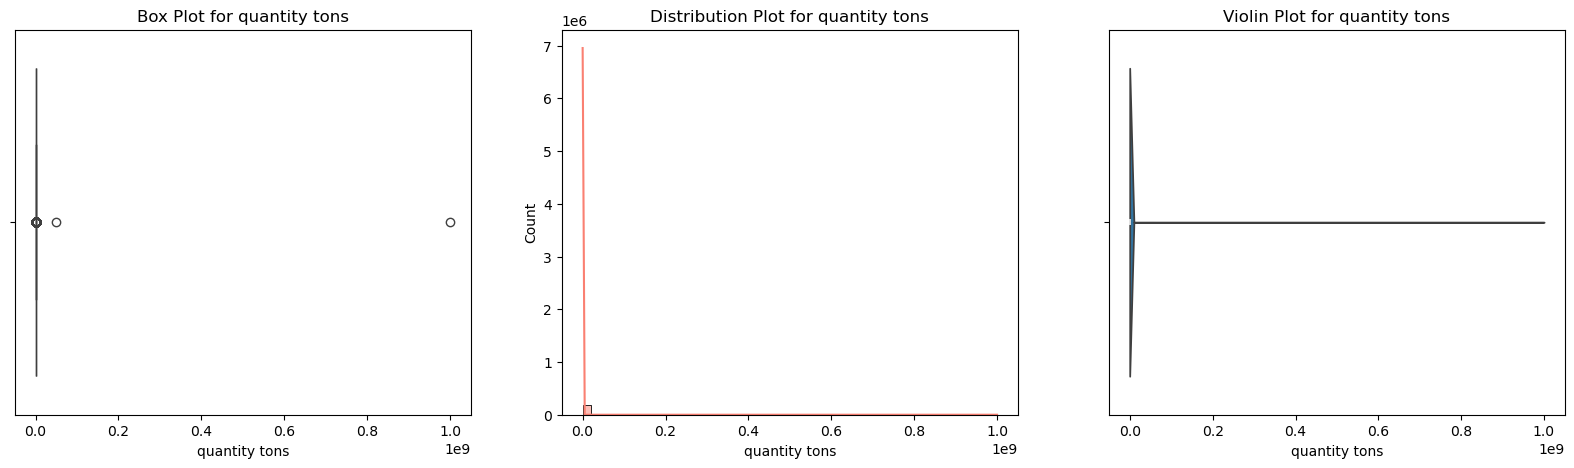

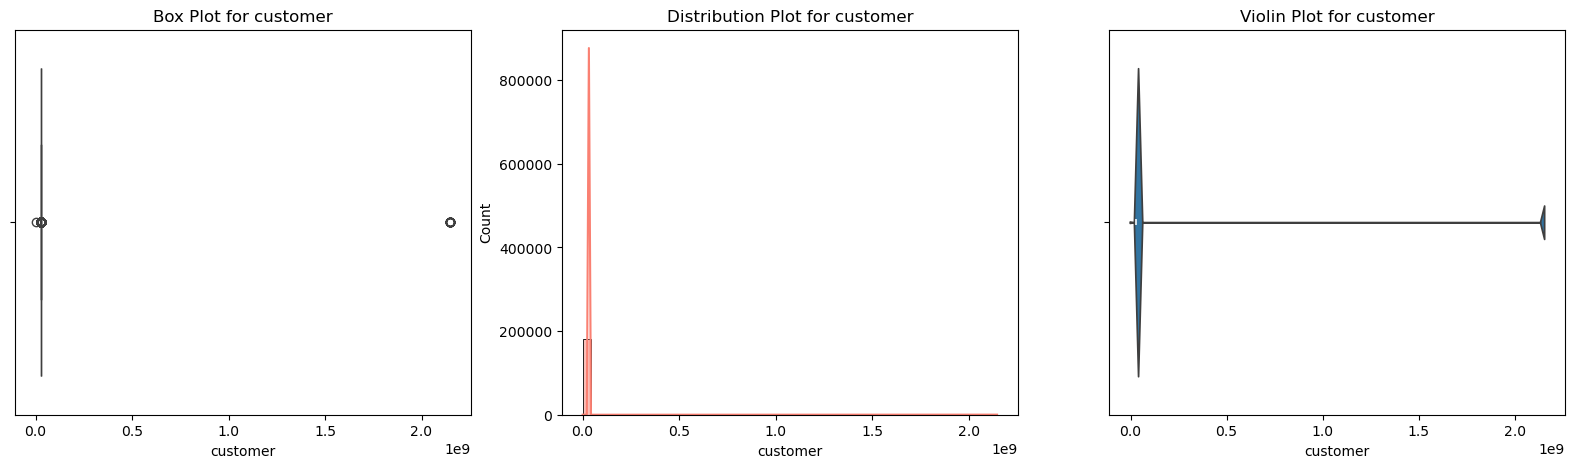

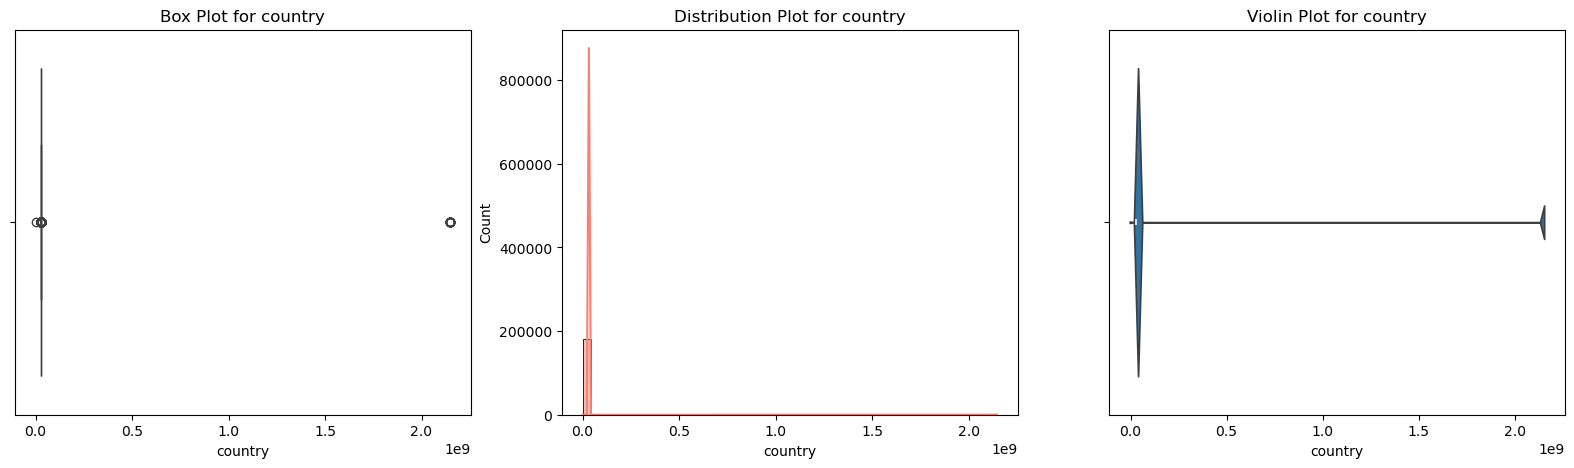

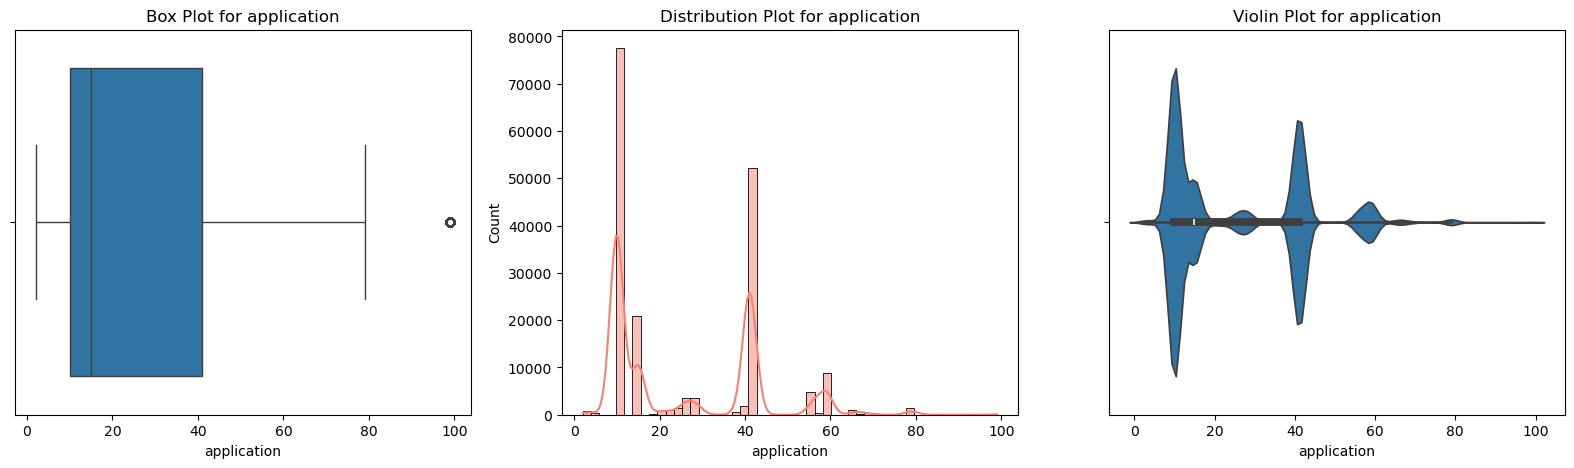

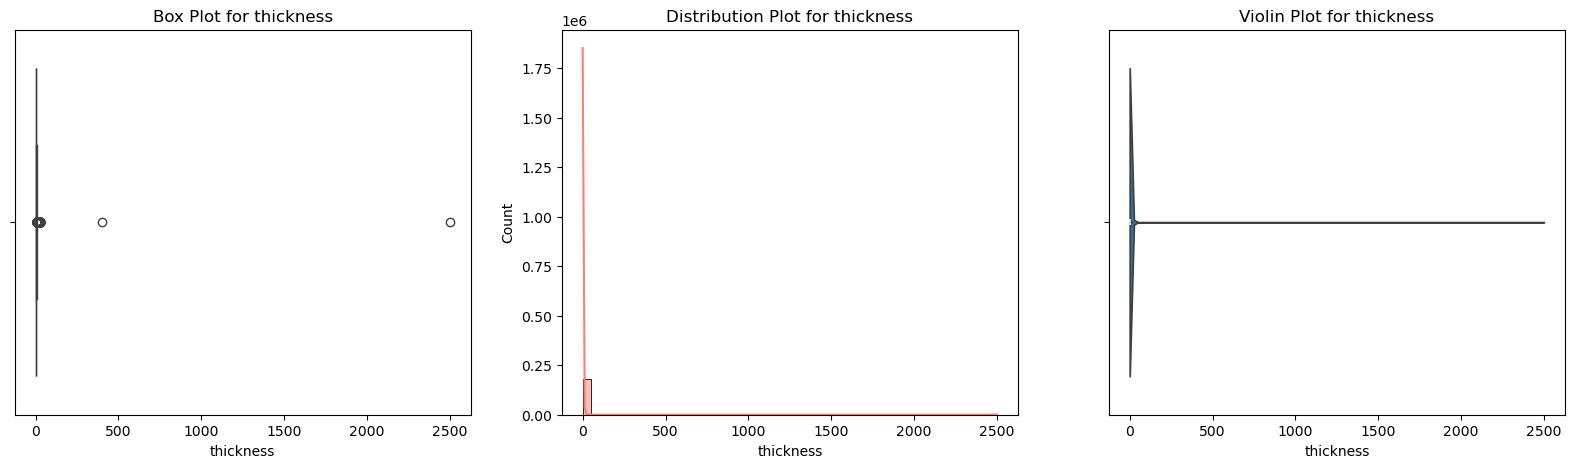

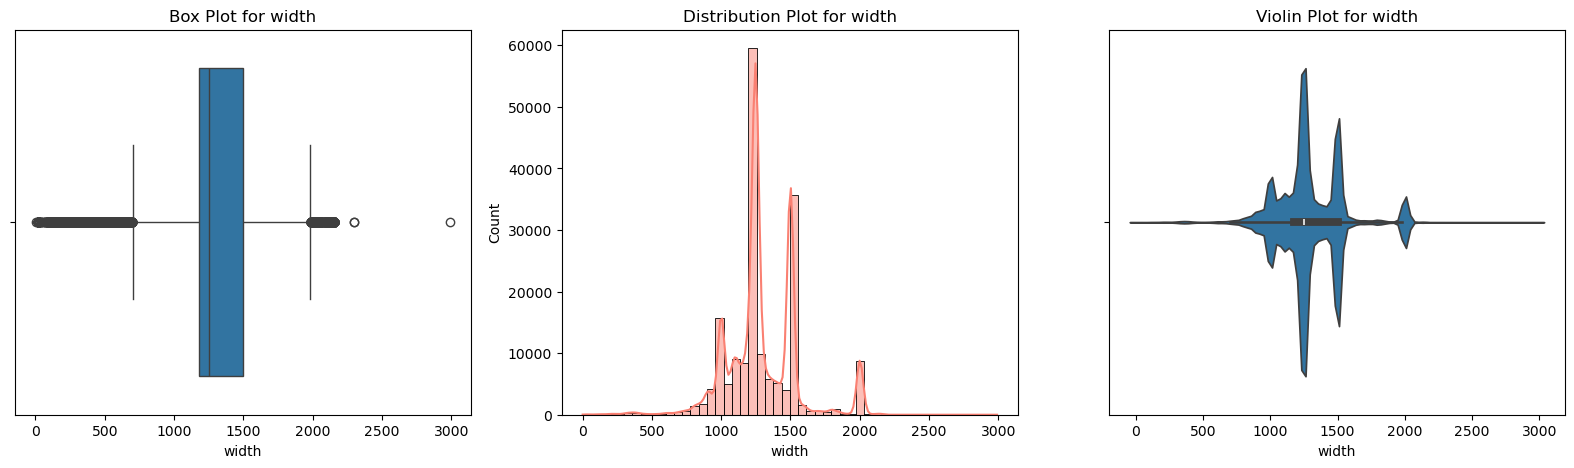

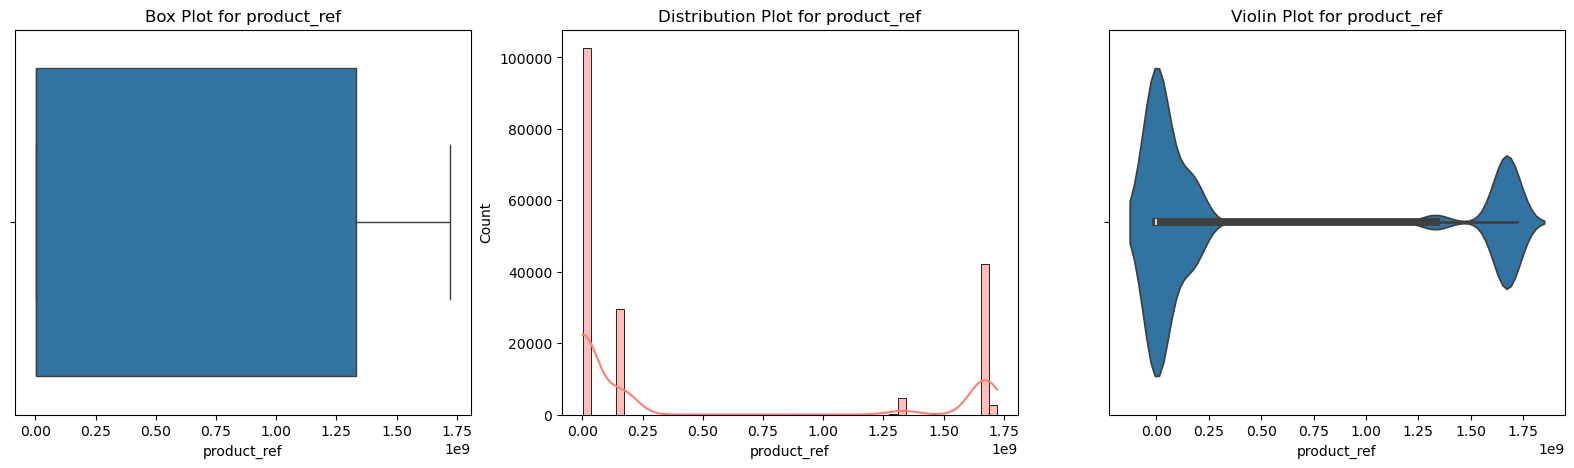

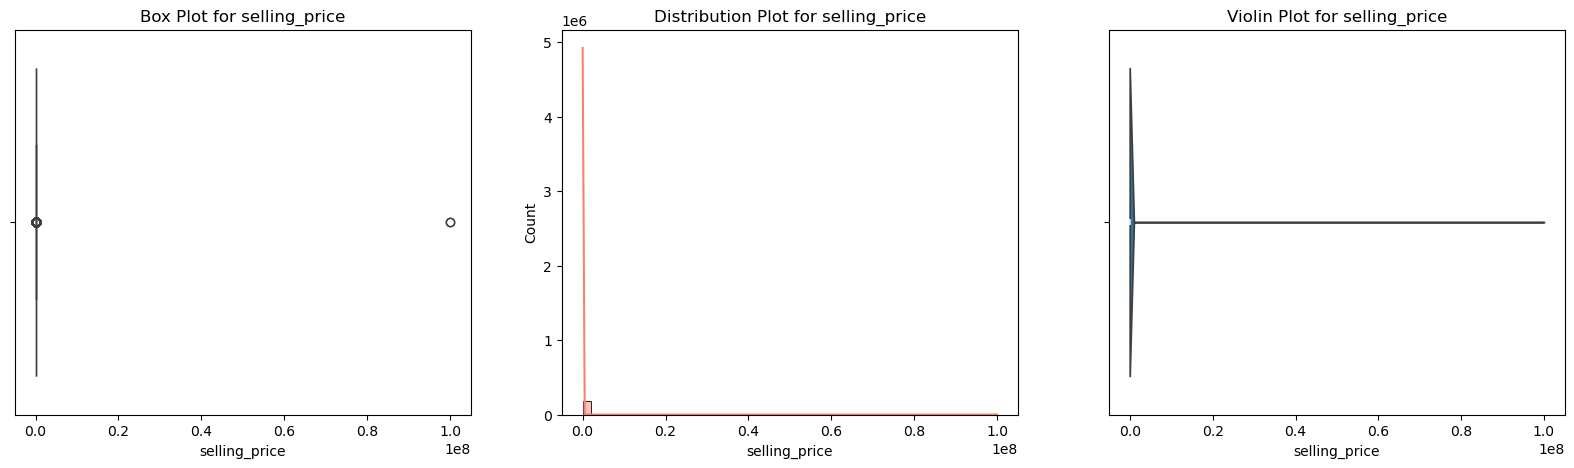

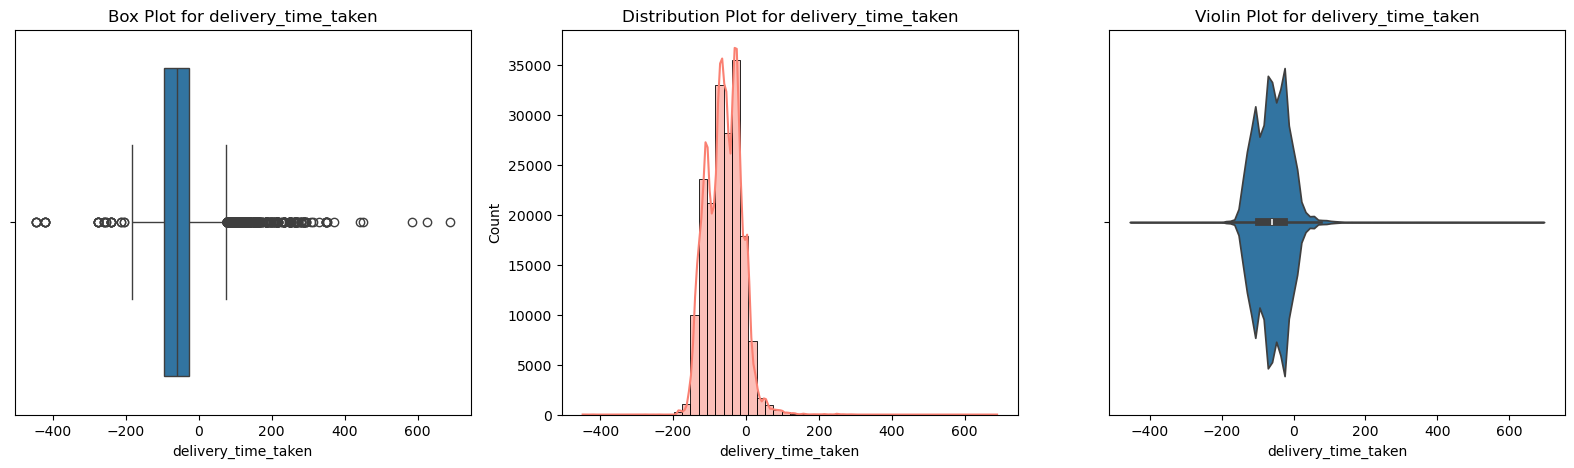

In [20]:
for i in ['quantity tons', 'customer', 'country', 'application', 'thickness', 'width', 'product_ref', 'selling_price', 'delivery_time_taken']:
    plot(df_1, i)

In [21]:
df_1['quantity_tons_log']=np.log(df_1['quantity tons'])
df_1['thickness_log']=np.log(df_1['thickness'])
df_1['selling_price_log']=np.log(df_1['selling_price'])
df_1.head()

,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,selling_price,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,54.151139,30156308.0,30156308.0,Won,W,10.0,2.00,1500.0,1670798778,854.00,-91.0,3.991779,0.693147,6.749931
1,768.024839,30202938.0,30202938.0,Won,W,41.0,0.80,1210.0,1668701718,1047.00,0.0,6.643822,-0.223144,6.953684
2,386.127949,30153963.0,30153963.0,Won,WI,28.0,0.38,952.0,628377,644.33,90.0,5.956169,-0.967584,6.468211
3,202.411065,30349574.0,30349574.0,Won,S,59.0,2.30,1317.0,1668701718,768.00,90.0,5.310301,0.832909,6.643790
4,785.526262,30211560.0,30211560.0,Won,W,10.0,4.00,2000.0,640665,577.00,31.0,6.666354,1.386294,6.357842


In [22]:
df_1.drop(columns=['quantity tons', 'thickness', 'selling_price'], inplace=True)
df_1.head()

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,30156308.0,Won,W,10.0,1500.0,1670798778,-91.0,3.991779,0.693147,6.749931
1,30202938.0,30202938.0,Won,W,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30153963.0,Won,WI,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,30349574.0,Won,S,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,30211560.0,Won,W,10.0,2000.0,640665,31.0,6.666354,1.386294,6.357842


In [23]:
#Handling Outliers with Interquartile range and Clipping

def outlier(df, column):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    upper_threshold = df[column].quantile(0.75) + (1.5*iqr)
    lower_threshold = df[column].quantile(0.25) - (1.5*iqr)
    df[column] = df[column].clip(lower_threshold, upper_threshold)

In [24]:
outlier(df_1,'quantity_tons_log')
outlier(df_1,'thickness_log')
outlier(df_1,'selling_price_log')
outlier(df_1,'width')
df_1

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,30156308.0,Won,W,10.0,1500.0,1670798778,-91.0,3.991779,0.693147,6.749931
1,30202938.0,30202938.0,Won,W,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30153963.0,Won,WI,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,30349574.0,Won,S,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,30211560.0,Won,W,10.0,1980.0,640665,31.0,6.666354,1.386294,6.357842
...,...,...,...,...,...,...,...,...,...,...,...
181668,30200854.0,30200854.0,Won,W,41.0,1220.0,164141591,1.0,4.629691,-0.040822,6.381816
181669,30200854.0,30200854.0,Won,W,41.0,1500.0,164141591,1.0,5.337954,-0.051293,6.378426
181670,30200854.0,30200854.0,Won,W,41.0,1250.0,164141591,1.0,1.443523,-0.342490,6.428105
181671,30200854.0,30200854.0,Won,W,41.0,1250.0,164141591,1.0,3.413291,-0.162519,6.398595


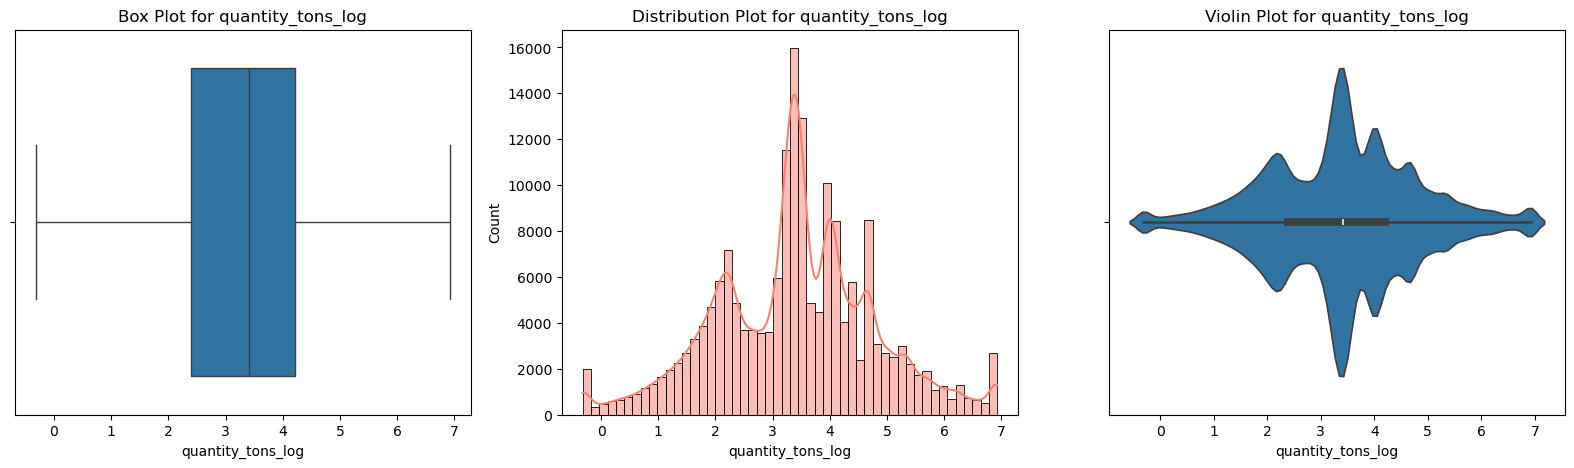

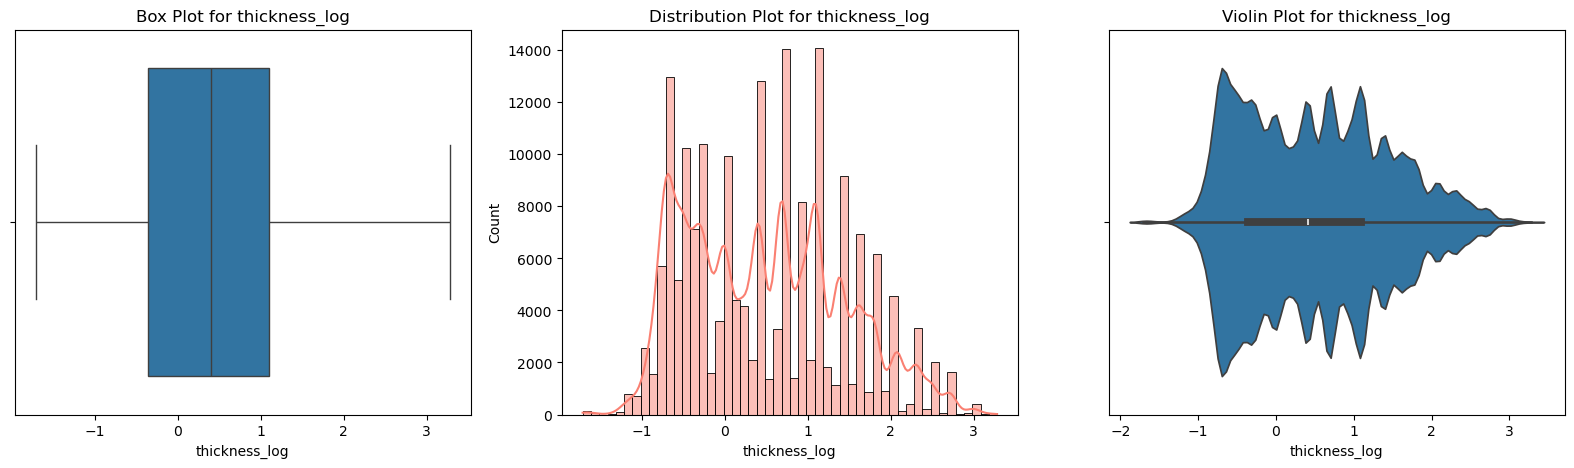

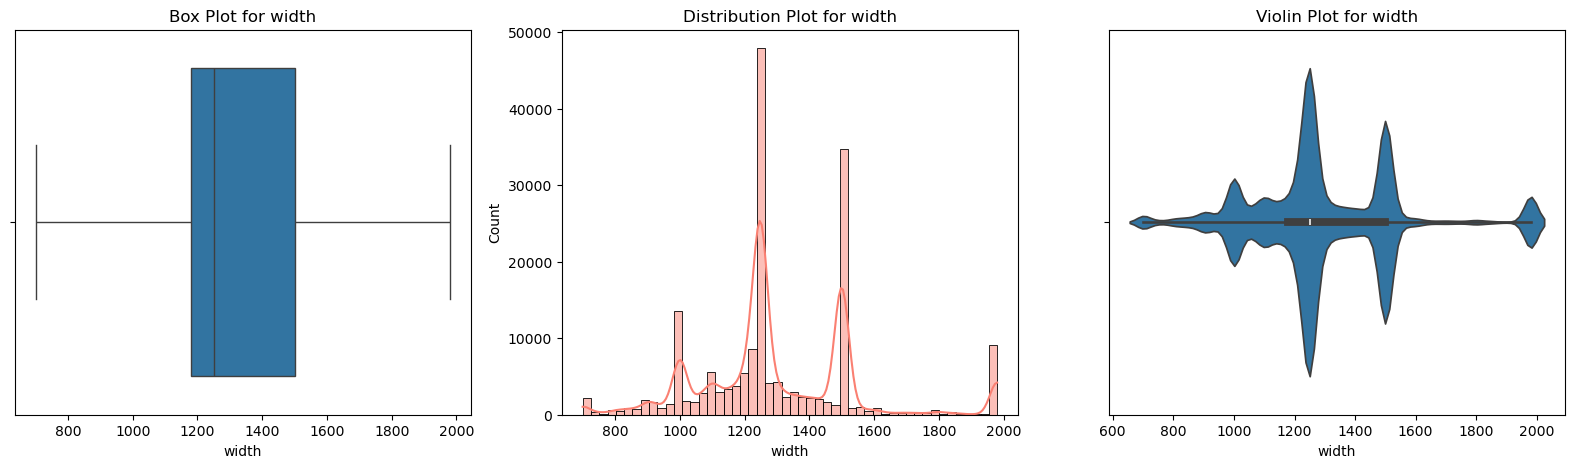

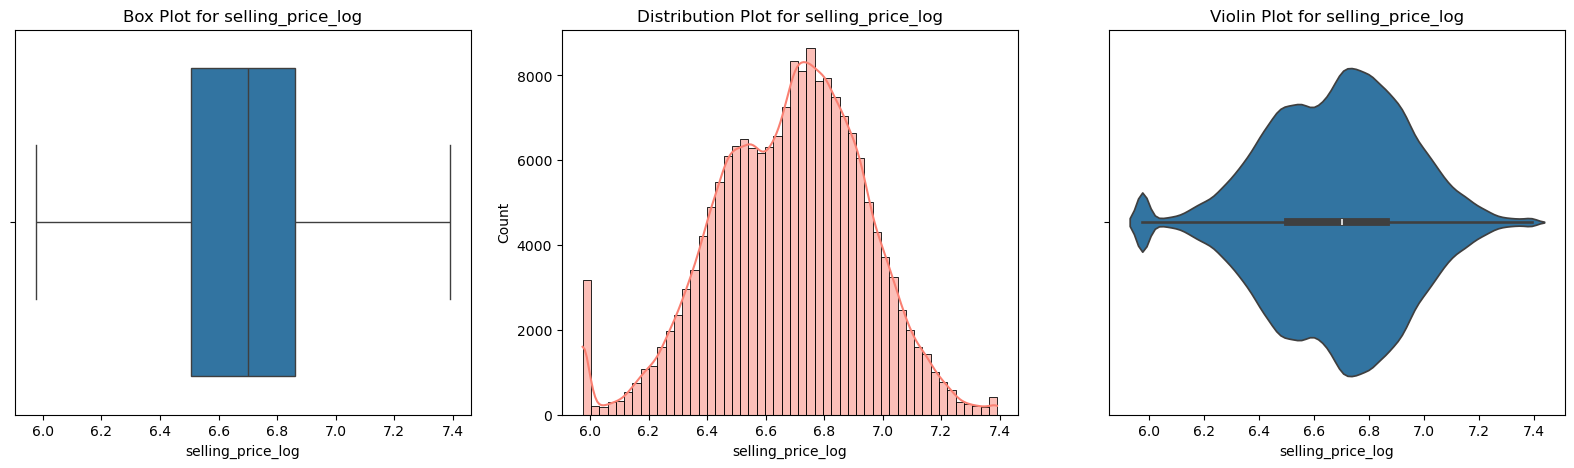

In [25]:
for i in ['quantity_tons_log', 'thickness_log', 'width', 'selling_price_log']:
    plot(df_1, i)

<Axes: >

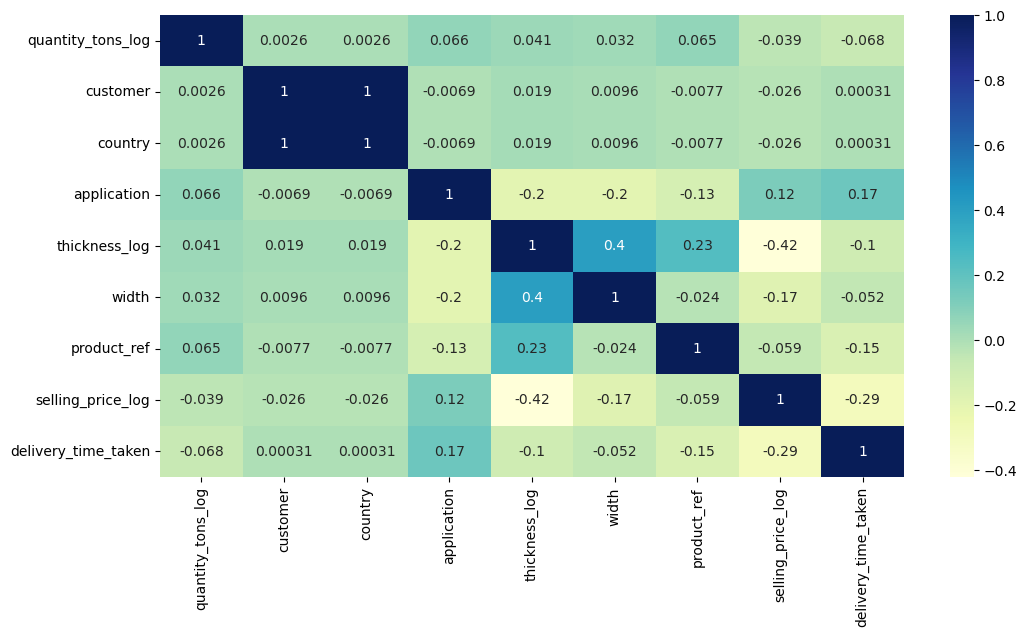

In [26]:
#Heatmap to verify Correlation
cor = df_1[['quantity_tons_log', 'customer', 'country', 'application', 'thickness_log', 'width', 'product_ref', 'selling_price_log', 'delivery_time_taken']].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(cor, annot=True, cmap='YlGnBu')

In [27]:
#Regression Model to predict Selling Price
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn import metrics
import pickle

In [28]:
df_2=df_1.copy()
df_2

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,30156308.0,Won,W,10.0,1500.0,1670798778,-91.0,3.991779,0.693147,6.749931
1,30202938.0,30202938.0,Won,W,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30153963.0,Won,WI,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,30349574.0,Won,S,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,30211560.0,Won,W,10.0,1980.0,640665,31.0,6.666354,1.386294,6.357842
...,...,...,...,...,...,...,...,...,...,...,...
181668,30200854.0,30200854.0,Won,W,41.0,1220.0,164141591,1.0,4.629691,-0.040822,6.381816
181669,30200854.0,30200854.0,Won,W,41.0,1500.0,164141591,1.0,5.337954,-0.051293,6.378426
181670,30200854.0,30200854.0,Won,W,41.0,1250.0,164141591,1.0,1.443523,-0.342490,6.428105
181671,30200854.0,30200854.0,Won,W,41.0,1250.0,164141591,1.0,3.413291,-0.162519,6.398595


In [29]:
print("Missing values in df_2:")
print(df_2.isnull().sum())

Missing values in df_2:
customer               0
country                0
status                 0
item type              0
application            0
width                  0
product_ref            0
delivery_time_taken    0
quantity_tons_log      0
thickness_log          0
selling_price_log      0
dtype: int64


In [30]:
df_2['status'].value_counts()

status
Won                116012
Lost                34438
Not lost for AM     19573
Revised              4276
To be approved       4170
Draft                3140
Offered                53
Offerable              10
Wonderful               1
Name: count, dtype: int64

In [31]:
#Encoding the values using map function
df_2['status']=df_2['status'].map({"Won":1, "Draft":2, "To be approved":3, "Lost":0, "Not lost for AM":4, "Wonderful":5, "Revised":6, 
                                   "Offered":7, "Offerable":8})
df_2['status'].unique()

array([1, 2, 3, 0, 4, 5, 6, 7, 8], dtype=int64)

In [32]:
df_2['item type'].value_counts()

item type
W         105615
S          69236
PL          5660
Others       610
WI           524
IPL           27
SLAWR          1
Name: count, dtype: int64

In [33]:
df_2['item type']=OrdinalEncoder().fit_transform(df_2[['item type']])
df_2['item type'].unique()

array([5., 6., 3., 1., 2., 0., 4.])

In [34]:
df_2.head()

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,30156308.0,1,5.0,10.0,1500.0,1670798778,-91.0,3.991779,0.693147,6.749931
1,30202938.0,30202938.0,1,5.0,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30153963.0,1,6.0,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,30349574.0,1,3.0,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,30211560.0,1,5.0,10.0,1980.0,640665,31.0,6.666354,1.386294,6.357842


In [36]:
#Defining a function to choose the appropriate algorithm
def best_ML_algorithm(df, algorithms):
    x=df.drop(columns=['selling_price_log'], axis=1)
    y=df['selling_price_log']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    results={}
    for algorithm in algorithms:
        model=algorithm().fit(x_train, y_train)
        y_pred=model.predict(x_test)
        MAE=metrics.mean_absolute_error(y_test, y_pred)
        MSE=metrics.mean_squared_error(y_test, y_pred)
        RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
        R2=metrics.r2_score(y_test,y_pred)
        results[algorithm.__name__]={'Mean Absolute Error':MAE, 'Mean Squared Error':MSE, 'Root Mean Squared Error':RMSE, 'R2 Score':R2}
    best_algorithm = max(results.items(),key=lambda item: item[1]['R2 Score'])[0]
    return best_algorithm, results

algorithms= [LinearRegression, DecisionTreeRegressor, ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, XGBRegressor]
best_algorithm, results=best_ML_algorithm(df_2, algorithms)
results_df=pd.DataFrame(results).transpose()
print("***Evaluation Metrics for Algorithms***")
print(results_df.to_string())

print("Best suitable Algorithm", best_algorithm)

***Evaluation Metrics for Algorithms***
                           Mean Absolute Error  Mean Squared Error  Root Mean Squared Error  R2 Score
LinearRegression                      0.162865            0.045216                 0.212640  0.306834
DecisionTreeRegressor                 0.055134            0.010482                 0.102384  0.839303
ExtraTreesRegressor                   0.047754            0.005858                 0.076541  0.910189
RandomForestRegressor                 0.046793            0.005646                 0.075137  0.913453
GradientBoostingRegressor             0.119856            0.022209                 0.149027  0.659531
XGBRegressor                          0.081003            0.011570                 0.107566  0.822623
Best suitable Algorithm RandomForestRegressor


In [39]:
x=df_2.drop(columns=['selling_price_log'],axis=1)
y=df_2['selling_price_log']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

param_grid = { 
    'n_estimators' :[100,150],
    'max_depth': [10,20],     
    'min_samples_split': [2,4], 
    'min_samples_leaf': [1,2],
    'max_features'    : ['sqrt', 'log2', None] }


grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                            param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(x_train, y_train)

grid_search.best_params_,grid_search.best_score_

({'max_depth': 20,
  'max_features': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 150},
 0.8908757389477002)

In [40]:
x=df_2.drop(columns=['selling_price_log'],axis=1)
y=df_2['selling_price_log']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
model_regressor = RandomForestRegressor(n_estimators=150, max_features=None, max_depth=20, min_samples_leaf=1, min_samples_split=2, random_state=42)
model_regressor.fit(x_train, y_train)
y_pred = model_regressor.predict(x_test)

MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2=metrics.r2_score(y_test,y_pred)

print(f"Mean Absolute Error:{MAE}")
print(f"Mean Squared Error:{MSE}")
print(f"Root Mean Squared Error:{RMSE}")
print(f"R2 Score:{R2}")

Mean Absolute Error:0.04991992909331204
Mean Squared Error:0.006009861197114882
Root Mean Squared Error:0.07752329454502616
R2 Score:0.9078677711440446


In [41]:
feature_scores = pd.Series(model_regressor.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_scores

product_ref            0.298944
delivery_time_taken    0.259691
status                 0.171113
country                0.054968
customer               0.054844
thickness_log          0.046140
quantity_tons_log      0.045648
application            0.027743
item type              0.020836
width                  0.020075
dtype: float64

In [42]:
with open('Regressor.pkl','wb') as files:
    pickle.dump(model_regressor,files)

In [43]:
with open('Regressor.pkl', 'rb') as files:
    predict_model=pickle.load(files)
pre=predict_model.predict(np.array([[30156308.0,28.0,1,5.0,10.0,1500.0,1670798778,91.0,3.991779,0.693147]]))
np.exp(pre[0])

559.4544746487104

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

# Filter out the values (won|lost) in status column
df_3 = df_2[(df_2.status == 1) | (df_2.status == 0)]

X = df_3.drop(columns=['status'])  
y = df_3['status']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(X, y)

# Define the function to test various algorithms
def best_ML_class_algo(x_smote, y_smote, algorithms):
    x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=42)
    
    results = {}

    for algorithm in algorithms:
        model = algorithm().fit(x_train, y_train)
        y_pred = model.predict(x_test)

        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)

        results[algorithm.__name__] = {
            'Accuracy score': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        }

    best_algorithm = max(results.items(), key=lambda item: item[1]['Accuracy score'])[0]  
    return best_algorithm, results  

# Define the algorithms to test
algorithms = [
    DecisionTreeClassifier, 
    ExtraTreesClassifier, 
    RandomForestClassifier,
    GradientBoostingClassifier, 
    XGBClassifier
]

# Find the best algorithm and get the results
best_algorithm, results = best_ML_class_algo(x_smote, y_smote, algorithms)

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(results).transpose()

print("**Evaluation Metrics for All Algorithms:**")
print(results_df.to_string())

print("**Best Algorithm:**", best_algorithm)

# Further hyperparameter tuning with GridSearchCV for the best algorithm
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, 25],     
    'min_samples_split': [2, 4],  
    'min_samples_leaf': [1, 2]
}

model = ExtraTreesClassifier(random_state=42) 

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1)

grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

**Evaluation Metrics for All Algorithms:**
                            Accuracy score  Precision    Recall  F1-score
DecisionTreeClassifier            0.954991   0.956592  0.952695  0.954640
ExtraTreesClassifier              0.977574   0.987461  0.967172  0.977211
RandomForestClassifier            0.975894   0.985835  0.965381  0.975501
GradientBoostingClassifier        0.799621   0.819264  0.765901  0.791684
XGBClassifier                     0.927997   0.947524  0.905303  0.925932
**Best Algorithm:** ExtraTreesClassifier
Best Parameters: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.9594374965662184


In [62]:
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=42)
model_classifier=ExtraTreesClassifier(n_estimators=100, max_depth=25, min_samples_leaf=1, min_samples_split=2)
model_classifier.fit(x_train, y_train)
y_pred=model_classifier.predict(x_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[34635   368]
 [ 2189 32416]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     35003
           1       0.99      0.94      0.96     34605

    accuracy                           0.96     69608
   macro avg       0.96      0.96      0.96     69608
weighted avg       0.96      0.96      0.96     69608



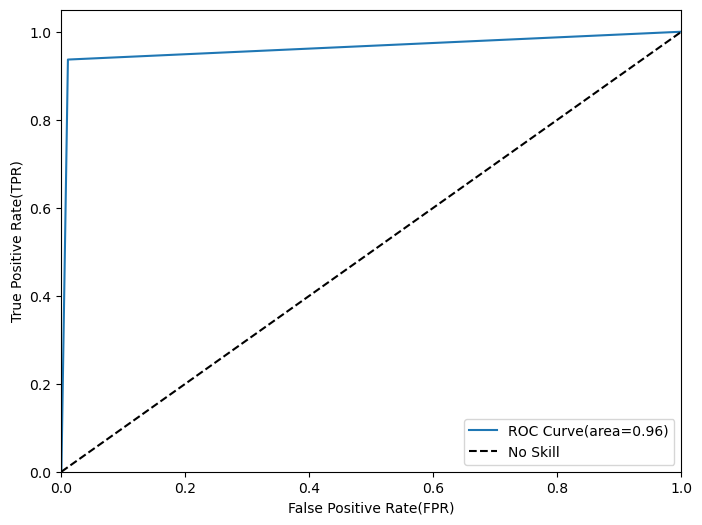

In [63]:
#Receiver Operating Characterstics Curve(ROC) and Area Under the Curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_curve = auc(x=fpr, y=tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='ROC Curve(area=%0.2f)' % auc_curve)
plt.plot([0,1], [0,1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.legend(loc="lower right")
plt.show()

In [65]:
#Feature Score
feature_scores=pd.Series(model_classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_scores

delivery_time_taken    0.176027
item type              0.141785
customer               0.118237
country                0.116922
application            0.106741
quantity_tons_log      0.093797
selling_price_log      0.075255
thickness_log          0.063567
product_ref            0.062788
width                  0.044881
dtype: float64

In [67]:
#Storing the model using pickle
with open('Classifier.pkl','wb') as files:
    pickle.dump(model_classifier, files)

In [68]:
#Loading the pickle and predict the status
with open('Classifier.pkl','rb') as files:
    model=pickle.load(files)
classifier=model.predict(np.array([[30156308.0,28.0,5.0,10.0,1500.0,1670798778,91.0,3.991779,0.693147,6.749931]]))
if classifier[0]==1:
    print('Won')
else:
    print('Loss')

Won


In [69]:
data={
    "Data":[
        "id",
        "item_date",
        "quantity tons",
        "customer",
        "country",
        "status",
        "item type",
        "application",
        "thickness",
        "width",
        "material_ref",
        "product_ref",
        "delivery date",
        "selling_price"
    ],
    "Define":[
        "Unique identifier for tracking transactions or items",
        "Date of transaction or item recording",
        "Quantity of items in tons",
        "Name or Identifier of Customer",
        "Country associated with Customer",
        "Current status of Transaction or item",
        "Category fo items",
        "Specific use or applicatin of items",
        "Details about thickness of the items",
        "Width of the items",
        "Reference for material used in the items",
        "Reference for specific product",
        "Expected or Actual Delivery Datefor the items",
        "Selling price of the items"
    ],
    "Range":[
        "Minimum Value: 10000",
        "DD/MM/YYYY",
        "(0.1, Maximum Value)",
        "(10000, Maximum Value)",
        "NA",
        "NA",
        "NA",
        "NA",
        "(0.18, 400)",
        "(1.0, 2990.0)",
        "(0, Maximum Value)",
        "(0, Maximum Value)",
        "DD/MM/YYYY",
        "(0.1, 100001015)"
    ]
}
df_list=pd.DataFrame(data)    

In [70]:
df_list

,Data,Define,Range
0,id,Unique identifier for tracking transactions or...,Minimum Value: 10000
1,item_date,Date of transaction or item recording,DD/MM/YYYY
2,quantity tons,Quantity of items in tons,"(0.1, Maximum Value)"
3,customer,Name or Identifier of Customer,"(10000, Maximum Value)"
4,country,Country associated with Customer,NA
5,status,Current status of Transaction or item,NA
6,item type,Category fo items,NA
7,application,Specific use or applicatin of items,NA
8,thickness,Details about thickness of the items,"(0.18, 400)"
9,width,Width of the items,"(1.0, 2990.0)"


In [72]:
df_list.to_csv('Data_Description.csv', index=False)

In [73]:
df.to_csv('df_coppernew.csv', index=False)